# Optimal Unitary Gate 

This notebook will serve as a test ground for implementing an optimal unitary gate in a dissapative system.

In [41]:
# Import libraries
import numpy as np

import time

import torch
from torch import nn
from torch.autograd import Variable
import torch.optim.lr_scheduler as lr_scheduler

from scipy.interpolate import CubicSpline

import matplotlib.pyplot as plt

In [42]:
# Define type for torch
exp_dtype = torch.complex128

# Define Pauli matrices for two level system
sigma_x = torch.tensor([[0,1],[1,0]], dtype=exp_dtype)
sigma_y = torch.tensor([[0,-1j],[1j,0]], dtype=exp_dtype)
sigma_z = torch.tensor([[1,0],[0,-1]], dtype=exp_dtype)
sigma_plus = torch.tensor([[0, 1], [0, 0]], dtype=exp_dtype)
sigma_minus = torch.tensor([[0, 0], [1, 0]], dtype=exp_dtype)
I = torch.eye(2, dtype=exp_dtype)

In [43]:
# Multiple spin operators

def X_k(k, N):
    return torch.kron(
        torch.kron(
            torch.eye(k), sigma_x
        ), torch.eye(N-(k-1))
    )

def Y_k(k, N):
    return torch.kron(
        torch.kron(
            torch.eye(k), sigma_y
        ), torch.eye(N-(k-1))
    )

def Z_k(k, N):
    return torch.kron(
        torch.kron(
            torch.eye(k), sigma_z
        ), torch.eye(N-(k-1))
    )

def sigma_plus_k(k, N):
    return torch.kron(
        torch.kron(
            torch.eye(k), sigma_plus
        ), torch.eye(N-(k-1))
    )

def sigma_plus_k(k, N):
    return torch.kron(
        torch.kron(
            torch.eye(k), sigma_minus
        ), torch.eye(N-(k-1))
    )

def U_k(U, k, N):
    return torch.kron(
        torch.kron(
            torch.eye(k), U
        ), torch.eye(N-(k-1))
    )


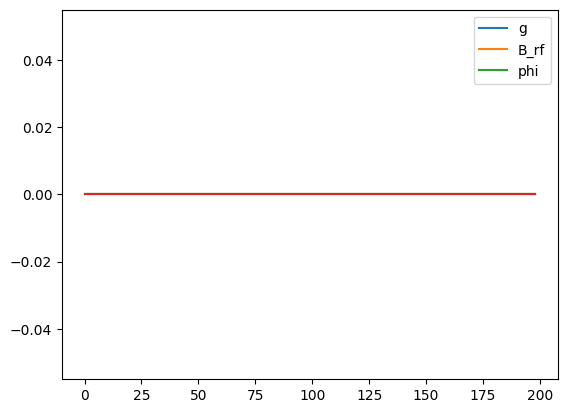

In [44]:
# Dice up the time
Ti, Tf = 0, 1e-6 # seconds
dt = 0.5e-8
t_units = np.arange(Ti, Tf-dt, dt)
M = int((Tf - Ti) // dt)
t = np.arange(M) 

# Number of spins
N = 2
isDispersive = True

# Plotting help
def bloch_animation(rhos, plot=False): 
    x,y,z,r=[],[],[],[] 
    for rho in rhos:
        X = np.real(np.trace(np.dot(rho, np.array([[0, 1], [1, 0]]))))
        Y = np.real(np.trace(np.dot(rho, np.array([[0, -1j], [1j, 0]]))))
        Z = np.real(np.trace(np.dot(rho, np.array([[1, 0], [0, -1]]))))
        R = np.sqrt(X**2 + Y**2 + Z**2)
        x.append(X)
        y.append(Y) 
        z.append(Z)
        r.append(R)

    if plot:
        plt.plot(t_units, x, c='r', label=r"$x(t)$")
        plt.plot(t_units, y, c='b', label=r"$y(t)$")
        plt.plot(t_units, z, c='g', label=r"$z(t)$")
        plt.title("State Vector")
        plt.legend(loc='best')
        plt.savefig("./results/xyz_state.png", dpi=300, bbox_inches="tight")
        plt.show()

        plt.plot(t_units, r, c='k', label=r"$r(t)$")
        plt.title("R Value")
        plt.ylim([0,2])
        plt.legend(loc='best')
        plt.savefig("./results/r_value.png", dpi=300, bbox_inches="tight")
        plt.show()
        print(r)

        print(f"Starting: [{x[0]}, {y[0]}, {z[0]}] \n")
        print(f"Ending: [{x[-1]}, {y[-1]}, {z[-1]}]")
    else:
        return r
    
# Define control parameters
g = np.zeros(M)
B_rf = np.zeros(M) 
phi = np.zeros(M) 
J = np.zeros(M)

# Interpolate to give it some shape
interp_step = M // 2
scale = 10000

def interpolate_parameter(param, t, interp_step, scale):
    param[::interp_step] = np.random.rand(M // interp_step + 1) / scale # T
    param[0] = 0
    param[-1] = 0
    param = CubicSpline(t[::interp_step], param[::interp_step])
    return param(t)

# B_rf = interpolate_parameter(B_rf, t, interp_step, scale)
# g = interpolate_parameter(g, t, interp_step, scale)
# if offset_phi:
#     phi = interpolate_parameter(phi, t, interp_step, 1/np.pi)
# J = interpolate_parameter(J, t, interp_step, scale)

plt.plot(g, label="g")
plt.plot(B_rf, label="B_rf")
plt.plot(phi, label="phi")
plt.plot(J)
plt.legend(loc="best")
plt.show()

# Convert to optimization variables with torch properties
g = Variable(torch.tensor(g, dtype=exp_dtype), requires_grad=True)
B_rf = Variable(torch.tensor(B_rf, dtype=exp_dtype), requires_grad=True)
phi = Variable(torch.tensor(phi, dtype=exp_dtype), requires_grad=True)
J = Variable(torch.tensor(J, dtype=exp_dtype), requires_grad=True)


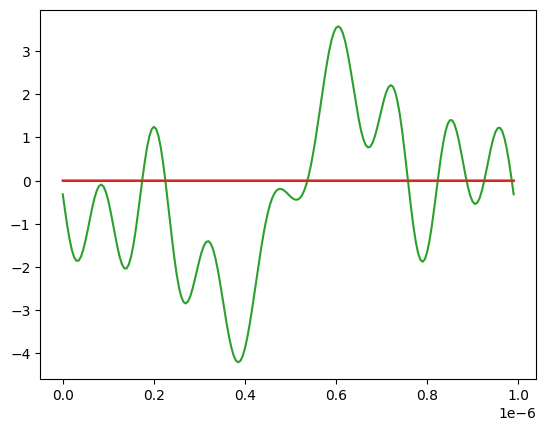

In [45]:
# Fourier series expansion

def fourier_series(t,*coeffs):
    n = len(coeffs[0])
    omega = 2 * np.pi / (t[-1]-t[0])
    f = torch.zeros_like(t)
    for i in range(n):
        f += coeffs[0][i].repeat(len(t)) * np.sin(i * omega * t)
    return f

def phi_fourier_series(t, *coeffs):
    n = len(coeffs[0])
    omega = 2 * np.pi / (t[-1]-t[0])
    f = torch.zeros_like(t)
    f += coeffs[0][-1]
    for i in range(n-1):
        f += coeffs[0][i].repeat(len(t)) * np.sin(i * omega * t)
    return f

K = 10
scale = 1e4
B_rf_coeffs = Variable(torch.tensor(np.random.randn(K)/scale), requires_grad=True) # Random initial coefficients
g_coeffs =  Variable(torch.tensor(np.random.randn(K)/scale), requires_grad=True) # Random initial coefficients
phi_coeffs = Variable(torch.tensor(np.random.randn(K+1)), requires_grad=True) # Random initial coefficients
J_coeffs =  Variable(torch.tensor(np.random.randn(K)), requires_grad=True) # Random initial coefficients

t_units_tensor = torch.tensor(t_units)

B_rf = fourier_series(t_units_tensor, B_rf_coeffs)
g = fourier_series(t_units_tensor, g_coeffs)
phi = phi_fourier_series(t_units_tensor, phi_coeffs)

plt.plot(t_units, B_rf.detach().numpy())
plt.plot(t_units, g.detach().numpy())
plt.plot(t_units, phi.detach().numpy())
plt.plot(t_units, J.detach().numpy())


In [46]:
# Helper functions to construct Lindbladian superoperator
def kron(A, B):
    return (A[:, None, :, None] * B[None, :, None, :]).reshape(A.shape[0] * B.shape[0], A.shape[1] * B.shape[1])
def kron_einsum(A,B):
    return torch.einsum("ij, kl->ikjl", A, B).view(A.size(0) * B.size(0), A.size(1)* B.size(1))
def hermitian_conj(A):
    return torch.conj(A).transpose(0,1)
def batch_kron(a, b):
    """
    Kronecker product of matrices a and b with leading batch dimensions.
    Batch dimensions are broadcast. The number of them mush
    :type a: torch.Tensor
    :type b: torch.Tensor
    :rtype: torch.Tensor
    """
    siz1 = torch.Size(torch.tensor(a.shape[-2:]) * torch.tensor(b.shape[-2:]))
    res = a.unsqueeze(-1).unsqueeze(-3) * b.unsqueeze(-2).unsqueeze(-4)
    siz0 = res.shape[:-4]
    return res.reshape(siz0 + siz1)

# Define constants
muB = 9.27e-24 # J/T
hbar = 1.055e-34 # Js
B0 = 607.285 * 1e-3 # Tesla, Bohdan's thesis page 120
kB = 1.38e-23 # J/K

w = 2 * muB * B0 / hbar # Larmor freq
on_resonance = False

f_rf = 17e9 # Hz
w_rf = 2 * np.pi * f_rf if not(on_resonance) else w 

# Define Lindblad operators
Te = 4 # K
T1 = 10e-3 # seconds
T2 = 10e-6 # seconds
P_up = 1 / (np.exp(hbar * w / (kB * Te)) + 1)
P_down = 1 - P_up

def L1_j(j, pj, T1, N):
    return U_k(np.sqrt(pj/(2*T1) * sigma_plus), j, N)
def L2_j(j, pj, T1, N):
    return U_k(np.sqrt((1-pj)/(2*T1) * sigma_minus), j, N)
def L3_j(j, T2, N):
    return U_k(np.sqrt(1/(2*np.sqrt(T2)) * sigma_z), j, N)

L1 = []
L2 = []
L3 = []

pj = P_up
for j in range(1, N+1):
    L1.append(L1_j(j, pj, T1, N))
    L2.append(L2_j(j, pj, T1, N))
    L3.append(L3_j(j, T2, N))
L = np.array([L1, L2, L3])


# Construct superoperator 
def construct_superop(g, B_rf, phi, J, L, N, dispersive=False):

    H = torch.zeros((M, 2**(N), 2**(N)), dtype=exp_dtype) # must be faster way ??
    for k in range(1,N+1):
        H += 0.5 * ((1 + g.view(-1, 1, 1)/2) * w - w_rf) * Z_k(k, N).repeat(M, 1, 1) + 0.5 * (2 * muB / hbar) * B_rf.view(-1, 1, 1) * (torch.cos(phi).view(-1, 1, 1) * X_k(k, N).repeat(M, 1, 1) + torch.sin(phi).view(-1, 1, 1) * Y_k(k,N).repeat(M, 1, 1))
    
    for j in range(1, N): # Issue if N > 2
        H += ( J.view(-1,1,1) / (4 * hbar) ) * (X_k(j, N) * X_k(j+1, N) + Y_k(j, N) * Y_k(j+1, N) + Z_k(j, N) * Z_k(j+1, N))

    Gamma = torch.zeros((M, 2**(2 * N), 2**(2 * N)), dtype=exp_dtype)
    for alpha in range(3):
        for j in range(N):
            Gamma += 2 * batch_kron(L[alpha, j].repeat(M,1,1), L[alpha, j].repeat(M,1,1)) - (batch_kron(torch.eye(2**N).repeat(M,1,1), torch.matmul(hermitian_conj(L[alpha,j]), L[alpha,j]).repeat(M,1,1)) + batch_kron(torch.matmul(L[alpha,j].transpose(0,1), L[alpha,j].conj()).repeat(M,1,1), torch.eye(2**N).repeat(M,1,1)))

    L = -1j * (batch_kron(H, torch.eye(2**N).repeat(M,1,1)) - batch_kron(torch.eye(2**N).repeat(M,1,1), H.transpose(1,2))) + int(dispersive) * Gamma
    exp_L = torch.matrix_exp(L * dt)
    L_F = torch.chain_matmul(*exp_L)
    return L_F

t0 = time.time()
L_F = construct_superop(g, B_rf, phi, J, L, N)
print("Time to create superoperator: ", time.time() - t0)

Time to create superoperator:  0.015940189361572266


/var/folders/y1/9bcvzg492znbq7qj0rhkdfp00000gn/T/ipykernel_67374/3788859743.py:56: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  L = np.array([L1, L2, L3])
/var/folders/y1/9bcvzg492znbq7qj0rhkdfp00000gn/T/ipykernel_67374/3788859743.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  L = np.array([L1, L2, L3])


In [47]:
# # Construct superoperator
# def L_F(g, B_rf, phi, J, L, dispersive=False):
#     Gamma = torch.zeros((M, 4, 4), dtype=exp_dtype)
#     for i in range(M):
#         H_rf = 0.5 * ((1 + g[i]/2) * w - w_rf) * sigma_z + 0.5 * (2 * muB / hbar) * B_rf[i] * (torch.cos(phi[i]) * sigma_x + torch.sin(phi[i]) * sigma_y)
#         Gamma[i] = -1j * (kron(H_rf, I) - kron(I, H_rf.transpose(0,1))) + L_total if dispersive else -1j * (kron(H_rf, I) - kron(I, H_rf.transpose(0,1)))
#     exp_Gamma = torch.matrix_exp(Gamma * dt)
#     product = torch.eye(4, dtype=exp_dtype)
#     for matrix in exp_Gamma: # Use torch.einsum? 
#         product = torch.mm(product, matrix)
#     return product

# Evolves rho at each time step and concatonates into an array
# def evolve_rho(rho0, B_rf, g, phi, dispersive=False):
#     rhos = torch.zeros((M, 2, 2), dtype=exp_dtype)
#     rhos[0] = rho0
#     Gamma = torch.zeros((M, 4, 4), dtype=exp_dtype)
#     for i in range(M):
#         H_rf = 0.5 * ((1 + g[i]/2) * w - w_rf) * sigma_z + 0.5 * (2 * muB / hbar) * B_rf[i] * (torch.cos(phi[i]).item() * sigma_x + torch.sin(phi[i]).item() * sigma_y)
#         Gamma[i] = -1j * (kron(H_rf, I) - kron(I, H_rf.transpose(0,1))) + L_total if dispersive else -1j * (kron(H_rf, I) - kron(I, H_rf.transpose(0,1)))
#     exp_Gamma = torch.matrix_exp(Gamma * dt)
#     for i in range(1,M): # should be more efficient way
#         rhos[i] = torch.matmul(exp_Gamma[i], rhos[i-1].view(-1,)).view(2,2)
#     return rhos, rhos.detach().numpy()

### Desired operator
def RX(theta):
    return torch.from_numpy(np.array([[np.cos(theta/2), -1j * np.sin(theta/2)], [-1j * np.sin(theta/2),np.cos(theta/2)]])).type(exp_dtype)
def RY(theta):
    return torch.from_numpy(np.array([[np.cos(theta/2), -np.sin(theta/2)], [np.sin(theta/2),np.cos(theta/2)]])).type(exp_dtype)
theta =np.pi/2
UF = torch.kron(RY(theta), torch.eye(2)) if N==2 else RY(theta)

L_desired = kron(UF.conj(), UF)

# Check out density matrices
rho0_spin1 =  torch.from_numpy(np.array([[1,0],[0,0]])).type(exp_dtype) # psi0 = |g>
rho0_spin2 =  torch.from_numpy(np.array([[1,0],[0,0]])).type(exp_dtype) # psi0 = |g>
rho0 = torch.kron(rho0_spin1, rho0_spin2) if N == 2 else rho0_spin1

rho_desired = torch.matmul(
            L_desired, rho0.view(-1,)
        )
rho = torch.matmul(
            construct_superop(g, B_rf, phi, J, L, N, dispersive=isDispersive), rho0.view(-1,)
        )


# print(L_F(g, B_rf, phi, J, L))
# print(L_desired)
print(rho_desired.view(2**N,2**N))
print(rho.view(2**N,2**N))



tensor([[0.5000+0.j, 0.0000+0.j, 0.5000+0.j, 0.0000+0.j],
        [0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j],
        [0.5000+0.j, 0.0000+0.j, 0.5000+0.j, 0.0000+0.j],
        [0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j]],
       dtype=torch.complex128)
tensor([[ 0.1185-2.9199e-05j, -0.1569-4.6056e-02j, -0.1569-4.6056e-02j,
          0.1898+1.2199e-01j],
        [-0.1569+4.6032e-02j,  0.2257-1.3201e-05j,  0.2256+9.7968e-05j,
         -0.2987-8.7752e-02j],
        [-0.1569+4.6032e-02j,  0.2256+9.7968e-05j,  0.2257-1.3201e-05j,
         -0.2987-8.7752e-02j],
        [ 0.1899-1.2185e-01j, -0.2988+8.7594e-02j, -0.2988+8.7594e-02j,
          0.4297+5.5593e-05j]], dtype=torch.complex128,
       grad_fn=<ViewBackward0>)


In [48]:
from torch.fft import fft

class CostFunction(nn.Module):
    def __init__(self):
        super(CostFunction, self).__init__()

    def forward(self, output, target, opt_params):

        fidelity = (torch.abs(torch.trace(
            torch.mm(
                hermitian_conj(output), target
            )
        )) / (2*N)**2)

        # loss = nn.L1Loss()

        # g, B_rf, phi = opt_params

        # rho, _ = evolve_rho(rho0, B_rf, g, phi, dispersive=False)

        # rhos_new = torch.zeros((M, 2, 2), dtype=exp_dtype)
        # rhos_new[0] = rho0.clone()
        # Gamma_new = torch.zeros((M, 4, 4), dtype=exp_dtype)
        # for i in range(M):
        #     H_rf_new = 0.5 * ((1 + g[i].clone()/2) * w - w_rf) * sigma_z + 0.5 * (2 * muB / hbar) * B_rf[i].clone() * (torch.cos(phi[i].clone()).item() * sigma_x + torch.sin(phi[i].clone()).item() * sigma_y)
        #     Gamma_new[i] = -1j * (kron(H_rf_new, I) - kron(I, H_rf_new.transpose(0,1))) + L_total if False else -1j * (kron(H_rf_new, I) - kron(I, H_rf_new.transpose(0,1)))
        # exp_Gamma_new = torch.matrix_exp(Gamma_new * dt)
        # for i in range(1,M):
        #     rhos_new[i] = torch.matmul(exp_Gamma_new[i], rhos_new[i-1].view(-1,)).view(2,2)
        # # with torch.no_grad():

        # R_array = bloch_animation(rhos_new.detach().numpy(), plot=False)
        # # print(R_array)
        # # print(rho_trace)
        # R_avg = torch.sum(torch.Tensor(R_array)) / M
      
        # # # Compute the real FFT of the signal along the last dimension
        # spectrum = torch.norm(torch.abs(fft(B_rf, dim=-1)[M//2::]))

        # # Compute the penalty term as the L2 norm of the derivative of the spectrum
        # freq_penalty = spectrum

        # penalty = 1e8
        # cost_start_stop = 0
 
        # cost_start_stop += penalty * torch.sum(torch.square(torch.abs(g[0])) + torch.square(torch.abs(g[-1]))).real
        # cost_start_stop += penalty * torch.sum(torch.square(torch.abs(B_rf[0])) + torch.square(torch.abs(B_rf[-1]))).real

        return  1 * torch.square(fidelity-1), fidelity, -1
        # return 1 * torch.square(fidelity-1) + 1 * loss(output, target) + cost_start_stop + 0 * torch.norm(g)**2 + 10 * torch.square(R_avg-1), fidelity, R_avg

opt_params = [g_coeffs, B_rf_coeffs, phi_coeffs]
lr_dict = {'g': 1e-6, 'B_rf': 1e-5, 'phi': 1e-3, 'J': 1e-29}
optimizer = torch.optim.Adam([{'params': g_coeffs, 'lr': lr_dict['g']},
                              {'params': B_rf_coeffs, 'lr': lr_dict['B_rf']},
                              {'params': phi_coeffs, 'lr': lr_dict['phi'],},
                              {'params': J, 'lr': lr_dict['J']}])

# opt_params = [g, B_rf, phi]
# lr_dict = {'g': 1e-6, 'B_rf': 1e-6, 'phi': 1e-2}
# optimizer = torch.optim.Adam([{'params': g, 'lr': lr_dict['g']},
#                               {'params': B_rf, 'lr': lr_dict['B_rf']},
#                               {'params': phi, 'lr': lr_dict['phi']}])
criterion = CostFunction()
# scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.6)

epochs = 500
loss_array = []
for i in range(epochs):
    optimizer.zero_grad()
    B_rf = fourier_series(t_units_tensor, B_rf_coeffs)
    g = fourier_series(t_units_tensor, g_coeffs)
    phi = phi_fourier_series(t_units_tensor, phi_coeffs)

    L_output = construct_superop(g, B_rf, phi, J, L, N, dispersive=isDispersive)
    loss, fid, R_avg = criterion(L_output, L_desired, opt_params)
    
    loss.backward()
    optimizer.step()

    loss_array.append(loss.item())
 
    if i % 100 == 0:
        print("Step {}: Loss = {}, Fidelity = {}, R Average = {}".format(i, loss.item(), fid,R_avg))

    if fid > 0.9999 and fid < 1:
        break

# print("Output superoperator: ", L_F(g, B_rf, phi, J, L), L_desired)
print("Final Fidelity = ", fid)

Step 0: Loss = 0.9798852809457468, Fidelity = 0.010108449906886599, R Average = -1


Output superoperator, 
  tensor([[ 0.0358-0.0021j,  0.0401-0.0571j,  0.0401-0.0571j,  0.1236-0.1024j,
          0.0428+0.0534j,  0.1331-0.0009j,  0.1331-0.0008j,  0.2959+0.0790j,
          0.0428+0.0534j,  0.1331-0.0008j,  0.1331-0.0009j,  0.2959+0.0790j,
          0.1249+0.0931j,  0.2927-0.0783j,  0.2927-0.0783j,  0.6973+0.0039j],
        [-0.0418+0.0539j,  0.0407+0.0097j, -0.1332+0.0892j,  0.0497-0.0475j,
         -0.1300-0.0054j,  0.0298+0.0739j, -0.2860-0.1086j,  0.1288+0.0249j,
         -0.1299-0.0055j,  0.0298+0.0739j, -0.2861-0.1086j,  0.1288+0.0248j,
         -0.2894+0.0626j,  0.1081+0.1458j, -0.6926-0.0747j,  0.2980-0.0192j],
        [-0.0418+0.0539j, -0.1332+0.0892j,  0.0407+0.0097j,  0.0497-0.0475j,
         -0.1299-0.0055j, -0.2861-0.1086j,  0.0298+0.0739j,  0.1288+0.0248j,
         -0.1300-0.0054j, -0.2860-0.1086j,  0.0298+0.0739j,  0.1288+0.0249j,
         -0.2894+0.0626j, -0.6926-0.0747j,  0.1081+0.1458j,  0.2980-0.0192j],
        [ 0.1343-0.0910j, -0.0507+0.0422j, -0.05

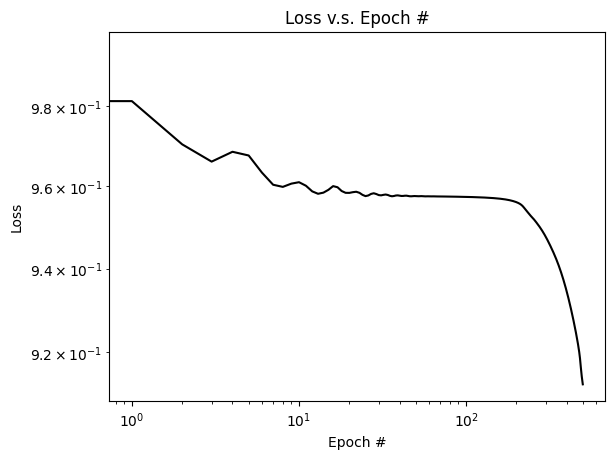

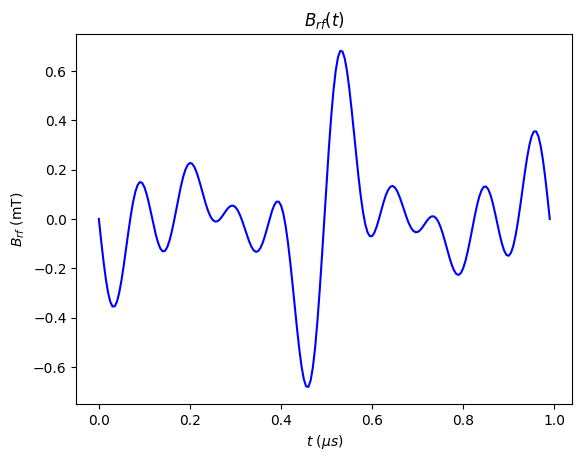

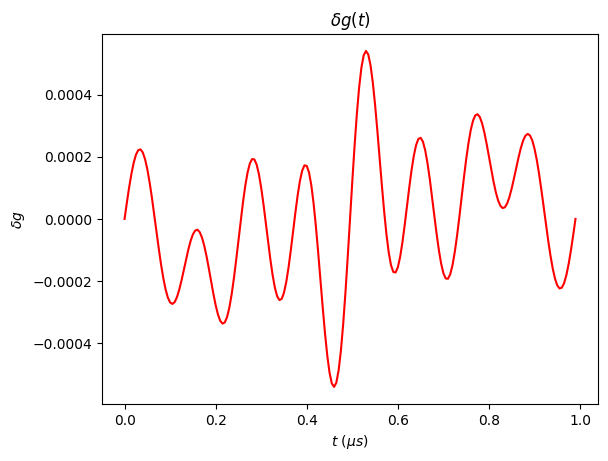

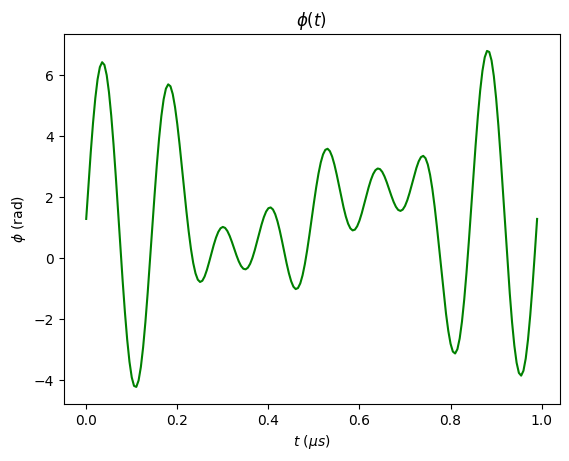

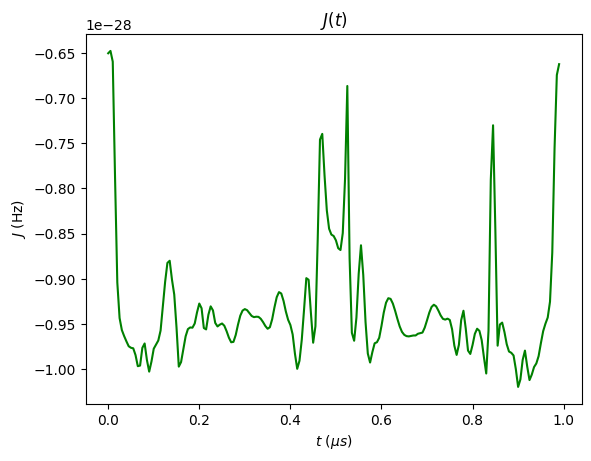

Rho Out:  tensor([[ 0.0357-0.0021j, -0.0419+0.0538j, -0.0419+0.0538j,  0.1343-0.0907j],
        [-0.0425-0.0505j,  0.1256+0.0023j,  0.1256+0.0024j, -0.2824-0.0980j],
        [-0.0425-0.0505j,  0.1256+0.0024j,  0.1256+0.0023j, -0.2824-0.0980j],
        [ 0.1354+0.0800j, -0.2843+0.0937j, -0.2843+0.0937j,  0.7125-0.0025j]],
       dtype=torch.complex128, grad_fn=<ViewBackward0>)
Rho Desired:  tensor([[0.5000+0.j, 0.0000+0.j, 0.5000+0.j, 0.0000+0.j],
        [0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j],
        [0.5000+0.j, 0.0000+0.j, 0.5000+0.j, 0.0000+0.j],
        [0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j]],
       dtype=torch.complex128)


In [ ]:
print("Output superoperator, \n ", construct_superop(g, B_rf, phi, J, L, N, dispersive=isDispersive))
print("Desired superoperator, \n ", L_desired)

# Print cost fxn 
plt.loglog(loss_array, 'k')
plt.title("Loss v.s. Epoch #")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.savefig('./results/loss.png', dpi=350, bbox_inches="tight")
plt.show()

# Show trained parameters
plt.plot(1e6 * t_units, 1e3 * B_rf.detach().numpy(), 'b')
plt.title(r"$B_{rf}(t)$")
plt.xlabel(r'$t\ (\mu s)$')
plt.ylabel(r"$B_{rf}\ $(mT)")
plt.savefig('./results/B_rf.png', dpi=350, bbox_inches="tight")
plt.show() 

plt.plot(1e6 * t_units, g.detach().numpy(), 'r')
plt.title(r"$\delta g(t)$")
plt.xlabel(r'$t\ (\mu s)$')
plt.ylabel(r"$\delta g$")
plt.savefig('./results/delta_g.png', dpi=350, bbox_inches="tight")
plt.show() 

plt.plot(1e6 * t_units, phi.detach().numpy(), 'g')
plt.title(r"$\phi(t)$")
plt.xlabel(r'$t\ (\mu s)$')
plt.ylabel(r"$\phi$ (rad)")
plt.savefig('./results/phi.png', dpi=350, bbox_inches="tight")
plt.show()

plt.plot(1e6 * t_units, J.detach().numpy(), 'g')
plt.title(r"$J(t)$")
plt.xlabel(r'$t\ (\mu s)$')
plt.ylabel(r"$J$ (Hz)")
plt.savefig('./results/J.png', dpi=350, bbox_inches="tight")
plt.show()

# See what L_f does to initial state
rho_out = torch.matmul(
            L_output, rho0.view(-1,)
        )
print("Rho Out: ", rho_out.view(2**N,2**N))
print("Rho Desired: ", rho_desired.view(2**N,2**N))


# Evolve rho
# rhos_tens, rhos_numpy = evolve_rho(rho0, B_rf, g, phi, dispersive=False)

# bloch_animation(rhos_numpy, plot=True)